In [4]:
import os
os.getcwd()
import numpy as np

In [5]:
from model import CascadeGenerator
from model import Discriminator
from model import  SketchClassifier
from CustomDataLoader import CreateDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm  #/home/user/Documents/SketchGAN_KAMALESH/sketchy/ 
import torchvision

In [6]:
dataset=CreateDataset('/home/user/Documents/SketchGAN_KAMALESH/sketchy/')

In [7]:
train_len=int(0.8*len(dataset))
#test_len=len(dataset)-train_len
#train_data,test_data=random_split(dataset,(train_len,test_len))
train_loader=DataLoader(dataset=dataset,batch_size=16,shuffle=False)
#test_loader=DataLoader(test_data,batch_size=16,shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


trial-2:
LAMBDA_1=100
LAMBDA_2=0.1
LAMBDA_3=1
lr_G=2e-4
lr=2e-5
step=3
threshold=1e-4  


trial-4:
LAMBDA_1=500
LAMBDA_2=0.1
LAMBDA_3=10
lr_G=5e-4
lr=2e-5
step=4
threshold=1e-4  


In [9]:
NUM_EPOCHS=150  # FILL
num_classes=11 # FILL
LAMBDA_1=500
LAMBDA_2=0.1
LAMBDA_3=10

BCE_loss=nn.BCEWithLogitsLoss()
L1_loss=nn.L1Loss()
CrossEntropy_loss=nn.CrossEntropyLoss()

G=CascadeGenerator(1,1)
D=Discriminator(1)
Classifier=SketchClassifier(1,num_classes)    #    define num_classes

checkpoint_classifier=torch.load('/home/user/Documents/SketchGAN_KAMALESH/checkpoints/Classifier/Classifier_11/SketchClassifier13.pth')
G.cuda()
D.cuda()
Classifier.load_state_dict(checkpoint_classifier['model_state_dict'])
Classifier.cuda()

optimizer_G=torch.optim.Adam(G.parameters(),betas=(0.5,0.999),lr=5e-4)
optimizer_D=torch.optim.Adam(D.parameters(),betas=(0.5,0.999),lr=2e-5)

In [12]:

steps=4

D_train_avgloss=[]
G_train_avgloss=[]
D_test_avgloss=[]
G_test_avgloss=[]
classifier_loss_avg=[]
PATH='/home/user/Documents/SketchGAN_KAMALESH/'
for epoch in tqdm(range(NUM_EPOCHS)):
    
    D_loss=[]
    G_loss=[]
    G.train()
    D.train()
    Classifier.eval()
    np.random.seed(20)
    for i,(path,input_,target,target_class,mask) in enumerate(train_loader):  #bring mask

        
        if epoch==0:
            print('Train Batch: {}'.format(i+1))
            for j in range(input_.size(0)):
                img_path=path[j]
                name=img_path.split('/')[-1]
                img_path=PATH+'Input_Masked/{}/'.format(img_path.split('/')[-2])
                if not os.path.exists(img_path):
                    os.makedirs(img_path)
                torchvision.utils.save_image(input_[j,:,:,:],img_path+'{}'.format(name))

        input_=input_.cuda()
        target=target.cuda()
        target_class=target_class.cuda()
        mask=mask.cuda()
        D_real=D(target,input_,mask)
        target_real=torch.ones(D_real.shape).cuda()
        D_real_loss=BCE_loss(D_real,target_real)
        G_out=G(input_)
        D_fake=D(G_out.detach(),input_,mask)  #remove 1
        target_fake=torch.zeros(D_fake.shape).cuda()
        D_fake_loss=BCE_loss(D_fake,target_fake)

        D_totalloss=0.5*(D_real_loss+D_fake_loss)   
        if D_totalloss.item()>1e-4:
            D.zero_grad()
            D_totalloss.backward()
            optimizer_D.step()
        for _ in range(steps):
            G_out=G(input_)
            D_fake=D(G_out,input_,mask)
            G_loss_=LAMBDA_3*BCE_loss(D_fake,target_real)
            l1_loss=L1_loss(G_out,target)

            classifier_out=Classifier(G_out)
            classifier_loss=LAMBDA_2*CrossEntropy_loss(classifier_out,torch.squeeze(target_class,1)) 

            
             
         #target of shape 1D required
            G.zero_grad()
            Classifier.zero_grad()
            classifier_loss.backward(retain_graph=True)
    
            G_totalloss=G_loss_+ LAMBDA_1*l1_loss
            
            G_totalloss.backward()
            optimizer_G.step()   
            G_loss.append(G_totalloss.item()) 
        D_loss.append(D_totalloss.item())
        
    D_train_avgloss.append(torch.mean(torch.FloatTensor(D_loss)))
    G_train_avgloss.append(torch.mean(torch.FloatTensor(G_loss)))
    D.eval()
    D_loss=[]
    G_loss=[]
    classifier_loss_ls=[]
    with torch.no_grad():
        for i,(path,input_,target,target_class,mask) in enumerate(test_loader):
            input_=input_.cuda()
            target=target.cuda()
            target_class=target_class.cuda()
            mask=mask.cuda()
            D_real=D(target,input_,mask)
            target_real=torch.ones(D_real.shape).cuda()
            D_real_loss=BCE_loss(D_real,target_real)
            G_out=G(input_)
            D_fake=D(G_out,input_,mask)  #remove 1
            target_fake=torch.zeros(D_fake.shape).cuda()
            D_fake_loss=BCE_loss(D_fake,target_fake)
    
            D_totalloss=0.5*(D_real_loss+D_fake_loss)   
  
            D_fake=D(G_out,input_,mask)
            G_loss_=LAMBDA_3*BCE_loss(D_fake,target_real)
            l1_loss=L1_loss(G_out,target)
    
            classifier_out=Classifier(G_out)
            classifier_loss=LAMBDA_2*CrossEntropy_loss(classifier_out,torch.squeeze(target_class,1)) 
            D_loss.append(D_totalloss.item())
            G_loss.append(G_totalloss.item())
            classifier_loss_ls.append(classifier_loss.item())
            for j in range(G_out.size(0)):
                img_path=path[j]  #os.makedirs(PATH+'Generated_output/Epoch{}'.format(epoch))
                name=img_path.split('/')[-1]
                img_path=PATH+'Generated_output/Epoch{}/{}/'.format(epoch,img_path.split('/')[-2])
                if not os.path.exists(img_path):
                    os.makedirs(img_path)
                torchvision.utils.save_image(G_out[j,:,:,:],img_path+'{}'.format(name))

        D_test_avgloss.append(torch.mean(torch.FloatTensor(D_loss)))
        G_test_avgloss.append(torch.mean(torch.FloatTensor(G_loss)))
        classifier_loss_avg.append(torch.mean(torch.FloatTensor(classifier_loss_ls)))
    
    print('Epoch: {}, D_train: {}, G_train: {}, D_test: {}, G_test: {}, class_test: {}'.format(epoch,D_train_avgloss[epoch].item(),G_train_avgloss[epoch].item(),D_test_avgloss[epoch].item(),G_test_avgloss[epoch].item(),classifier_loss_avg[epoch].item()))
    torch.save({'epoch':epoch,'disriminator_state':D.state_dict(),'generator_state':G.state_dict(),'dis_loss':D_test_avgloss[epoch].item(),'gen_loss':G_test_avgloss[epoch].item()}
    ,'/home/user/Documents/SketchGAN_KAMALESH/checkpoints/SketchGAN/SketchGAN{}.pth'.format(epoch))

  0%|          | 0/150 [00:00<?, ?it/s]

Train Batch: 1
Train Batch: 2
Train Batch: 3
Train Batch: 4
Train Batch: 5
Train Batch: 6
Train Batch: 7
Train Batch: 8
Train Batch: 9
Train Batch: 10
Train Batch: 11
Train Batch: 12
Train Batch: 13
Train Batch: 14
Train Batch: 15
Train Batch: 16
Train Batch: 17
Train Batch: 18
Train Batch: 19
Train Batch: 20
Train Batch: 21
Train Batch: 22
Train Batch: 23
Train Batch: 24
Train Batch: 25
Train Batch: 26
Train Batch: 27
Train Batch: 28
Train Batch: 29
Train Batch: 30
Train Batch: 31
Train Batch: 32
Train Batch: 33
Train Batch: 34
Train Batch: 35
Train Batch: 36
Train Batch: 37
Train Batch: 38
Train Batch: 39
Train Batch: 40
Train Batch: 41
Train Batch: 42
Train Batch: 43
Train Batch: 44
Train Batch: 45
Train Batch: 46
Train Batch: 47
Train Batch: 48
Train Batch: 49
Train Batch: 50
Train Batch: 51
Train Batch: 52
Train Batch: 53
Train Batch: 54
Train Batch: 55
Train Batch: 56
Train Batch: 57
Train Batch: 58
Train Batch: 59
Train Batch: 60
Train Batch: 61
Train Batch: 62
Train Batch: 63
T

  0%|          | 0/150 [11:12<?, ?it/s]


NameError: name 'test_loader' is not defined

In [8]:
import matplotlib.pyplot as plt

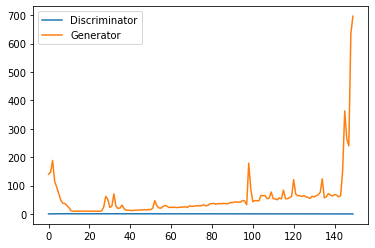

In [9]:
plt.figure()
plt.plot(np.arange(NUM_EPOCHS),D_train_avgloss,label='Discriminator')
plt.plot(np.arange(NUM_EPOCHS),G_train_avgloss,label='Generator')
plt.legend()
plt.show()